In [1]:
import numpy as np
import sys
sys.path.append('..')
sys.path.append('../..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
import skewer_computations as skc
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from scipy.interpolate import interp1d
import forestflow
import mask_calculations as mc
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck18 as P18
import os

In [2]:
def retrieve_masked_p1d(maskname, snapnum):
    p1ds_masked = []
    c=0
    for phase in ['plus','minus']:
        for ax in range(1,4):
            f = np.load(mask_path+f"skewers_{snapnum}_psim_{phase}_ax{ax}{maskname}_mask_p1d.npz")
            p1ds_masked.append(f['p1d_masked'])
            if c==0:
                kpar = f['kpar']
                L    = f['L_Mpc']
                Np   = f['Np']
            c+=1
    p1ds_masked = np.asarray(p1ds_masked)
    p1ds_masked_avg = np.average(p1ds_masked, axis=0)
    return kpar, L, Np, p1ds_masked_avg

Load the data

In [3]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
pix_spacing = 0.05


In [6]:
path_program = os.path.dirname(forestflow.__path__[0]) + '/'
folder_lya_data = path_program + "/data/best_arinyo/"
Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

In [7]:
# load the unmasked p1d measurement
sim = Archive3D.get_testing_data('mpg_central', force_recompute_plin=False)
sim_z = [d for d in sim if d["z"] == 3][0]

In [8]:
p1d_unmasked = sim_z['p1d_Mpc']

In [9]:
len(sim_z['k_Mpc'])

676

In [19]:
# load the masked P1D measurements
mask_path = "/data/desi/scratch/mlokken/masking/"

# mode = 'all'
# mode = '2skyline'
mode = 'skyline'
if mode=='all':
    kpar, L, Np, p1d_2skyline = retrieve_masked_p1d('double_skyline', 6)
    kpar, L, Np, p1d_dla = retrieve_masked_p1d('dla', 6)
    kpar, L, Np, p1d_randmasked = retrieve_masked_p1d('random', 6)
    kpar, L, Np, p1d_skyline = retrieve_masked_p1d('skyline', 6)

if mode=='2skyline':
    kpar, L, Np, p1d_2skyline = retrieve_masked_p1d('double_skyline', 6)
elif mode=='skyline':
    kpar, L, Np, p1d_skyline = retrieve_masked_p1d('skyline', 6)
elif mode=='random':
    kpar, L, Np, p1d_randmasked = retrieve_masked_p1d('random', 6)
elif mode=='dla':
    kpar, L, Np, p1d_dla = retrieve_masked_p1d('dla', 6)

In [20]:
if mode=='all':
    nmodes = 300
    kpar_cut = kpar[:nmodes]
    # wkcut = wk[:nmodes]
    wkcut = np.ones(nmodes)
    #set of 5 colors
    colors=['blue', 'orange', 'brown', 'green', 'red', 'purple']
    two_panel = False
    if two_panel:
        # make a three-panel figure with the lower panels smaller
        fig, ax = plt.subplots(2, 1, figsize=[8, 8], gridspec_kw={'height_ratios': [1, 1]}, sharex=True)
    
        ax[0].plot(kpar_cut, p1d_unmasked[:nmodes]/wkcut, 's', label='no masking', color=colors[5], alpha=.3)
        ax[0].plot(kpar_cut, p1d_randmasked[:nmodes]*L/Np**2/wkcut, '*', label=f'random masking', color=colors[1], alpha=.3)
        ax[0].plot(kpar_cut, p1d_skyline[:nmodes]*L/Np**2/wkcut, 'o', label=f'skyline masking', color=colors[2], alpha=.3)
        ax[0].plot(kpar_cut, p1d_2skyline[:nmodes]*L/Np**2/wkcut, 'x', label=f'double skyline masking', color=colors[3], alpha=.3)
        ax[0].plot(kpar_cut, p1d_dla[:nmodes]*L/Np**2/wkcut, '^', label=f'DLA masking', color=colors[4], alpha=.3)
        ax[0].set_xlim([0,6])
        ax[0].legend()
        ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
    
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=[6, 4])
        ax = [0,ax1]
    plt.suptitle(r"$P_{1D}$ from hydro simulation for different masks")
    
    ax[1].set_xlim([0,7])
    
    # plot the pct difference from no-masking in the lower panel
    ax[1].plot(kpar_cut, ((p1d_randmasked[:nmodes]*L/Np**2)/p1d_unmasked[:nmodes]-1)*100, linestyle='solid', color=colors[1], label='random masking')
    ax[1].plot(kpar_cut, ((p1d_skyline[:nmodes]*L/Np**2)/p1d_unmasked[:nmodes]-1)*100, linestyle='dashed', color=colors[2], label='skyline masking')
    ax[1].plot(kpar_cut, ((p1d_2skyline[:nmodes]*L/Np**2)/p1d_unmasked[:nmodes]-1)*100, linestyle='dashdot', color=colors[3], label='double skyline masking')
    ax[1].plot(kpar_cut, ((p1d_dla[:nmodes]*L/Np**2)/p1d_unmasked[:nmodes]-1)*100, linestyle='dotted', color=colors[4], label='DLA masking')
    ax[1].legend(loc='upper left')
    ax[1].axhline([0], color='k')
    ax[1].set_ylim([-1, 1])
    ax[1].set_ylabel('Percent difference from unmasked')
    ax[1].set_xlabel(r"$k_{\parallel}$ [Mpc$^{-1}$]")
    plt.savefig("p1d_hydro_four_masks_pctdiff.pdf")

In [21]:
# read the masks
maskdir = "/data/desi/scratch/mlokken/masking/"
masks = []
masknames = []
if mode=='all':
    for maskfile in ['random_mask.npy', 'skyline_mask.npy', 'double_skyline_mask.npy', 'dla_mask.npy']:
        masks.append(np.load(maskdir+maskfile))
        # ((nside, nside, Np)) reshape
        masknames.append(os.path.splitext(maskfile)[0])
elif mode=='2skyline':
    for maskfile in ['double_skyline_mask.npy']:
        masks.append(np.load(maskdir+maskfile))
        # ((nside, nside, Np)) reshape
        masknames.append(os.path.splitext(maskfile)[0])
elif mode=='skyline':
    for maskfile in ['skyline_mask.npy']:
        masks.append(np.load(maskdir+maskfile))
        # ((nside, nside, Np)) reshape
        masknames.append(os.path.splitext(maskfile)[0])

print(masknames)


['skyline_mask']


In [24]:
# FFT the masks
if mode=='all':
    skyline_mask_k = np.fft.fft(masks[1], axis=1)
    skyline_2mask_k = np.fft.fft(masks[2], axis=1)
    dla_mask_k = np.fft.fft(masks[3], axis=1)
    random_mask_k = np.fft.fft(masks[0], axis=1)
elif mode=='2skyline':
    skyline_2mask_k = np.fft.fft(masks[0], axis=1)
elif mode=='skyline':
    skyline_mask_k = np.fft.fft(masks[0], axis=1)
elif mode=='dla':
    dla_mask_k = np.fft.fft(masks[3], axis=1)
elif mode=='random':
    random_mask_k = np.fft.fft(masks[0], axis=1)
    

In [25]:
kmax = np.pi/pix_spacing
kbin_spacing = kpar[1]-kpar[0]

# make a set of bins with kpar as centers
kbin_est = np.array([[kp-(kpar[1]-kpar[0])/2, kp+(kpar[1]-kpar[0])/2] for kp in kpar])
Nbin = len(kbin_est)

In [ ]:
# # plot the deltas of the DLA masked skewers vs the originals
# plt.figure()
# # i = 90
# i = 0
# for j in range(100):
#     # plt.plot(xpar_b, delta_flux_b_grid[i, i], label='original')
#     # plt.plot(xpar_b, delta_flux_dla_b_grid[i, i], label='DLA masked')
#     # plt.plot(xpar_b, delta_flux_2skyline_b_grid[i, i], label='2 skylines masked')
#     plt.plot(xpar_b, delta_flux_dla_b_grid.real[i, j]-delta_flux_b_grid.real[i, j], label='DLA masked')

#     # plt.plot(xpar_b, delta_flux_randmasked_b_grid.real[i, i]-delta_flux_b_grid.real[i, i], label='random masked')
#     # plt.plot(xpar_b, delta_flux_2skyline_b_grid[i, i]-delta_flux_b_grid[i,i], label='2 skylines masked')
#     plt.plot(xpar_b, delta_flux_skyline_b_grid.real[i, j]-delta_flux_b_grid.real[i,j], label='1 skylines masked')
#     plt.ylim([-.5,.3])
#     plt.legend()
#     plt.show()
#     plt.clf()

    # # plot the delta flux k
    # plt.plot(kpar_b,delta_flux_k_grid[i,j], label='original')
    # plt.plot(kpar_b,delta_flux_randmasked_k_grid[i,j], label='random masked')
    # plt.plot(kpar_b,delta_flux_skyline_k_grid[i,j], label='skyline masked')
    # plt.plot(kpar_b,delta_flux_dla_k_grid[i,j], label='DLA masked')
    # plt.plot(kpar_b,delta_flux_2skyline_k_flat[i,j], label='double skyline masked')
    # plt.legend()
    # plt.show()
    # plt.clf()

Get the FFT measurements

In [47]:
def model_mask(nmodes, mask, p1d, lowmem=True):
    masked_p1d_est = np.zeros(nmodes)
    for m in range(nmodes):
        if m%10==0:
            print("Getting model for mode", m)
        if lowmem:
            masked_p1d_est[m] = mc.calculate_masked_power_fft_loop(m, mask, p1d)
        else:
            masked_p1d_est[m] = mc.calculate_masked_power_fft_array(m, mask, p1d)
    return masked_p1d_est

def plot_mask_model(nmodes, kpar, original_power, masked_power, masked_power_model, label, L=L, Np=Np):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
    kpar_cut = kpar[:nmodes]
    ax[0].plot(kpar_cut, original_power[:nmodes], label='unmasked', color='blue')
    ax[0].plot(kpar_cut, masked_power[:nmodes]*L/Np**2, label='after ' + label+ ' masking', color='orange')
    ax[0].plot(kpar_cut, masked_power_model*L/Np**2, linestyle='dotted', label='model of masked power', color='green')
    # ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')
    # ax[0].plot(kpar_cut, np.abs(skyline_2mask_k_flat[0, :nmodes])*L/Np**2, label='mask FFT')
    ax[0].set_ylim([0,.6])
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[1].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
    ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
    ax[0].set_xlim([.1,6])
    ax[1].plot(kpar_cut, ((masked_power[:nmodes]*L/Np**2)/original_power[:nmodes]-1)*100, label='masked vs unmasked', color='orange')
    ax[1].plot(kpar_cut, (masked_power_model[:nmodes]/(masked_power[:nmodes]*L/Np**2)-1)*100, label='model vs masked', color='green')
    ax[1].legend(loc=[.03, .8], framealpha=1)
    ax[1].set_ylabel("Percentage difference")
    ax[1].axhspan(-.5, .5, color='grey', alpha=0.5)
    ax[1].set_ylim([-1,1])
    # plt.savefig(f"p1d_hydro_{label}_mask_model.pdf")
    plt.show()
    plt.clf()

In [17]:
p1d_unmasked_full = np.concatenate((p1d_unmasked, p1d_unmasked[1:-1][::-1]))

In [50]:
nmodes = 60
if mode=='all':
    model_2skyline = model_mask(nmodes, skyline_2mask_k, p1d_unmasked_full)
    model_dla = model_mask(nmodes, dla_mask_k, p1d_unmasked_full)
    model_rand = model_mask(nmodes, random_mask_k, p1d_unmasked_full)
    model_skyline = model_mask(nmodes, skyline_mask_k, p1d_unmasked_full)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_randmasked, model_rand, 'random', L=L, Np=Np)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_skyline, model_skyline, 'skyline', L=L, Np=Np)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_dla, model_dla, 'DLA', L=L, Np=Np)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_2skyline, model_2skyline, 'double skyline', L=L, Np=Np)

elif mode=='2skyline':
    model_2skyline = model_mask(nmodes, skyline_2mask_k, p1d_unmasked_full, lowmem=True)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_2skyline, model_2skyline, 'double skyline', L=L, Np=Np)
elif mode=='skyline':
    model_skyline = model_mask(nmodes, skyline_mask_k, p1d_unmasked_full, lowmem=True)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_skyline, model_skyline, 'skyline', L=L, Np=Np)
elif mode=='dla':
    model_dla = model_mask(nmodes, dla_mask_k, p1d_unmasked_full, lowmem=True)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_dla, model_dla, 'DLA', L=L, Np=Np)
elif mode=='rand':
    model_rand = model_mask(nmodes, random_mask_k, p1d_unmasked_full, lowmem=True)
    plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_randmasked, model_rand, 'random', L=L, Np=Np)

Getting model for mode 0
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
Getting model for mode 10
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn_fft array
doing the array mode.
got the mask_mn

IOStream.flush timed out
IOStream.flush timed out


got the mask_mn_fft array
doing the array mode.
<NULL>


SystemError: CPUDispatcher(<function calculate_masked_power_fft_array at 0x7f7845129760>) returned a result with an exception set

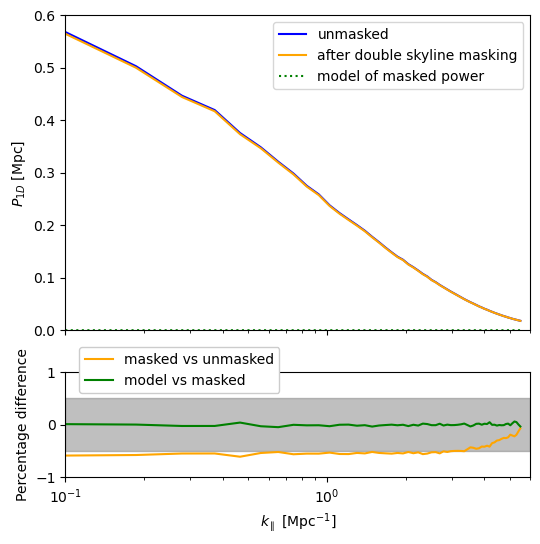

<Figure size 640x480 with 0 Axes>

In [164]:
plot_mask_model(nmodes, kpar, p1d_unmasked_full, p1d_2skyline, model_2skyline, 'double skyline', L=L, Np=Np)


In [ ]:
print("Lowest k mode that can be measured with full box is ", kpar[1], 2*np.pi/L, "the fundamental frequency")

In [255]:
# confirm that the optimal estimator produces an unbiased result
# do the setup
delta_x_matrix = est.make_delta_x_matrix(L, Np, xpar)
S_fiducial = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix, pix_spacing, plot=False)
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
xi_fid = np.fft.irfft(p1d_fine) / spacing_fine
xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C_0_mat = est.c0(xi_fid_func, delta_x_matrix)
C_0_invmat = np.linalg.inv(C_0_mat)

In [225]:
# do the fiducial measurement
kbin_centers, theta_est_p1d, F_alpha_beta_p1d, Lalpha_P1D = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_grid, kbin_est[:25], S_fiducial, C_0_invmat, approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324, 1.3962634015954634, 1.4893476283684943, 1.5824318551415253, 1.675516081914556, 1.768600308687587, 1.8616845354606177, 1.9547687622336487, 2.0478529890066794, 2.1409372157797106, 2.2340214425527414]
Getting derivative matrices.
Starting loop through data.
This k took 11.471966981887817 seconds
This k took 9.909932136535645 seconds
This k took 16.589059114456177 seconds
This k took 13.05282711982727 seconds
This k took 18.96342134475708 seconds
This k took 18.215703010559082 seconds
This k took 13.201503992080688 seconds
This k took 12.4863121509552 seconds
This k took 10.199319839477539 seconds
This k took 9.712335109710693 seconds
This k took 12.739845037460327 seconds
Thi

In [278]:
# do the masked measurements
kbin_centers, theta_est_p1d_rand, F_alpha_beta_p1d_rand, Lalpha_P1D_rand = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_randmasked_grid, kbin_est[:15], S_fiducial, C_0_invmat, C_0_mat=C_0_mat, weights=1/(random_mask+1e-5), approx_fisher=True)


Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324]
Getting derivative matrices.
Starting loop through data.
This k took 20.06328010559082 seconds
This k took 25.390316009521484 seconds
This k took 19.718116998672485 seconds
This k took 29.863620042800903 seconds
This k took 22.34372901916504 seconds
This k took 21.933873891830444 seconds
This k took 24.367255687713623 seconds
This k took 30.966569900512695 seconds
This k took 23.83536982536316 seconds
This k took 27.195455074310303 seconds
This k took 22.179786205291748 seconds
This k took 27.386509895324707 seconds
This k took 24.362816095352173 seconds
This k took 17.988892078399658 seconds
This k took 23.26703691482544 seconds


In [289]:
kbin_centers, theta_est_p1d_skyline, F_alpha_beta_p1d_skyline, Lalpha_P1D_skyline = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_skyline_grid, kbin_est[:15], S_fiducial, C_0_invmat,C_0_mat=C_0_mat,  weights=1/(skyline_mask+1e-5), approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324]
Getting derivative matrices.
Starting loop through data.
This k took 26.582276105880737 seconds
This k took 39.77098298072815 seconds
This k took 34.73501372337341 seconds
This k took 34.26375603675842 seconds
This k took 24.36147403717041 seconds
This k took 24.123600721359253 seconds
This k took 28.782420873641968 seconds
This k took 31.133329153060913 seconds
This k took 37.090906858444214 seconds
This k took 34.70977306365967 seconds
This k took 30.74790620803833 seconds
This k took 27.021751880645752 seconds
This k took 28.13994598388672 seconds
This k took 26.83265209197998 seconds
This k took 21.78049111366272 seconds


In [292]:
kbin_centers, theta_est_p1d_2skyline, F_alpha_beta_p1d_2skyline, Lalpha_P1D_2skyline = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_2skyline_grid, kbin_est[:15], S_fiducial, C_0_invmat,C_0_mat=C_0_mat,  weights=1/(skyline_2mask+1e-5), approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324]
Getting derivative matrices.
Starting loop through data.
This k took 22.828445196151733 seconds
This k took 20.60446572303772 seconds
This k took 24.44278597831726 seconds
This k took 22.28462505340576 seconds
This k took 25.761786937713623 seconds
This k took 26.210994958877563 seconds
This k took 23.809076070785522 seconds
This k took 21.34253215789795 seconds
This k took 21.76136088371277 seconds
This k took 28.216991901397705 seconds
This k took 34.29638695716858 seconds
This k took 28.285340785980225 seconds
This k took 33.32581663131714 seconds
This k took 25.271300792694092 seconds
This k took 16.9674870967865 seconds


In [ ]:
kbin_centers, theta_est_p1d_dla, F_alpha_beta_p1d_dla, Lalpha_P1D_dla = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_dla_grid, kbin_est[:25], S_fiducial, C_0_invmat, approx_fisher=True)

In [236]:
Nbin//2

135

In [246]:
p1d_fid = est.bin_model(kfine, p1d_fine, kbin_est[:135], Nbin//2-2)

In [290]:
kbin_centers = [(k[0]+k[1])/2. for k in kbin_est]


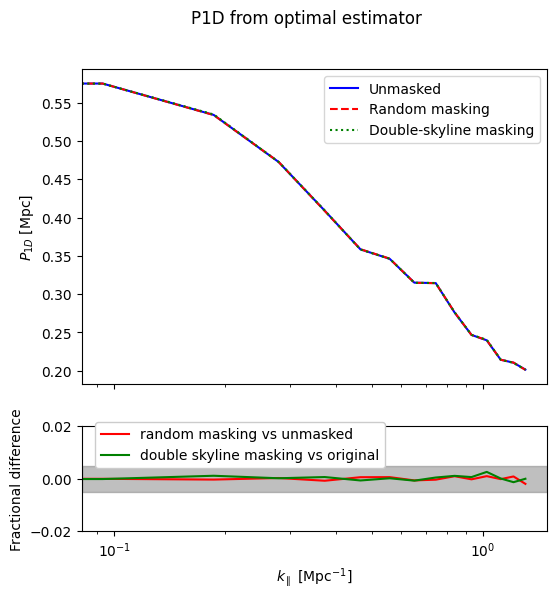

<Figure size 640x480 with 0 Axes>

In [301]:
nmodes = 15
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
kpar_cut = kbin_centers[:nmodes]
plt.suptitle("P1D from optimal estimator")
ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d[:nmodes], label='Unmasked', color='blue')
ax[0].plot(kpar_cut[:nmodes], p1d_fid[:nmodes]+theta_est_p1d_rand[:nmodes], label='Random masking', linestyle='dashed', color='red')
ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_2skyline[:nmodes], label='Double-skyline masking', linestyle='dotted', color='green')
ax[1].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
# ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_skyline[:nmodes], label='skyline masked')
# ax[0].plot(kpar_cut, theta_est_p1d_2skyline[:nmodes], label='double skyline masked')
# ax[0].plot(kpar_cut, theta_est_p1d_dla[:nmodes], label='DLA masked')
ax[1].plot(kpar_cut, (p1d_fid[:nmodes]+theta_est_p1d_rand[:nmodes])/(p1d_fid[:nmodes]+theta_est_p1d[:nmodes])-1, label='random masking vs unmasked', color='red')
ax[1].plot(kpar_cut, (p1d_fid[:nmodes]+theta_est_p1d_2skyline[:nmodes])/(p1d_fid[:nmodes]+theta_est_p1d[:nmodes])-1, label='double skyline masking vs original', color='green')
# ax[1].plot(kpar_cut, theta_est_p1d_2skyline[:nmodes]/theta_est_p1d[:nmodes]-1, label='double skyline masked vs original', color='purple')
# ax[1].plot(kpar_cut, theta_est_p1d_dla[:nmodes]/theta_est_p1d[:nmodes]-1, label='DLA masked vs original', color='red')
ax[1].legend(loc=[.03, .6], framealpha=1)
ax[1].set_ylabel("Fractional difference")
ax[1].axhspan(-.005, .005, color='grey', alpha=0.5)
ax[1].set_ylim([-.02,.02])
ax[0].legend()
ax[1].set_xscale('log')

plt.show()
plt.clf()
